In [6]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
#load data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


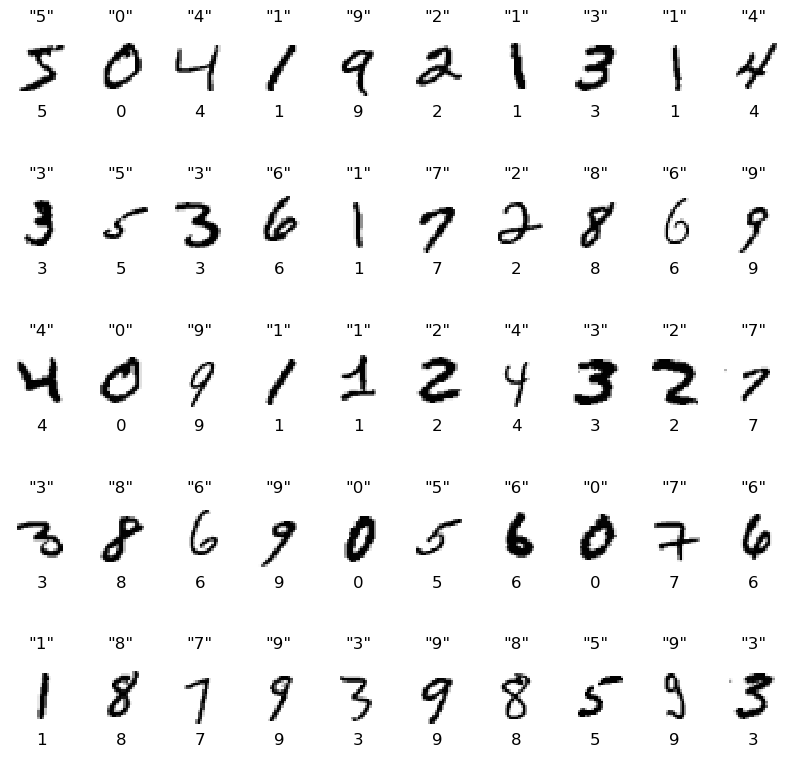

In [108]:
#function to plot images with labels
def plot_digit(data, actual_label=None, predicted_label=None, ax=None):
    if ax is None:
        ax = plt.gca()
    image = data.reshape(28, 28)  # Assuming image data is a flat 28x28 pixels
    ax.imshow(image, cmap='binary', interpolation='nearest')
    ax.axis('off')
    
    # Set the actual label to the left of the plot
    if actual_label is not None:
        ax.text(0.5, -0.1, str(actual_label), fontsize=12, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='center')
    
    # Set the predicted label as the title with quotes around it
    if predicted_label is not None:
        ax.set_title(f'"{predicted_label}"', fontsize=12, pad=10)


def plot_digits(instances, actualLabels=None, predictedLabels=None, images_per_row=10):
    size = 28  # Assuming each digit is 28x28 pixels
    n_images = len(instances)
    images_per_col = (n_images + images_per_row - 1) // images_per_row

    if actualLabels is not None:
        assert len(actualLabels) == n_images, "Mismatch between number of instances and actual labels"
    if predictedLabels is not None:
        assert len(predictedLabels) == n_images, "Mismatch between number of instances and predicted labels"

    # Create a single figure and axis structure for the entire plot
    fig, axs = plt.subplots(images_per_col, images_per_row, figsize=(images_per_row, 2 * images_per_col),
                            gridspec_kw={'wspace':0.25, 'hspace':0.1})
    axs = axs.flatten()  # Flatten the array for easy iteration

    for idx in range(len(axs)):
        if idx < n_images:
            plot_digit(instances[idx], 
                       actual_label=actualLabels[idx] if actualLabels is not None else None,
                       predicted_label=predictedLabels[idx] if predictedLabels is not None else None,
                       ax=axs[idx])
        else:
            axs[idx].axis('off')  # Hide empty subplots

    plt.show()

#plot digits
X, y = mnist["data"], mnist["target"]
plot_digits(X[:50], y[:50],y[:50])





In [9]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [10]:
#train Kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_train)

#predict
y_pred = knn_clf.predict(X_test)


In [11]:
#print parameters
print(knn_clf.n_neighbors)
print(knn_clf.weights)


5
uniform


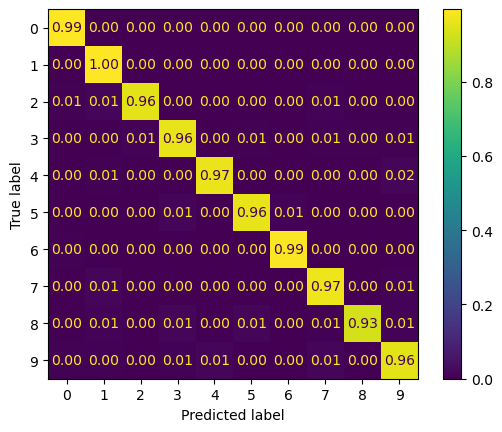

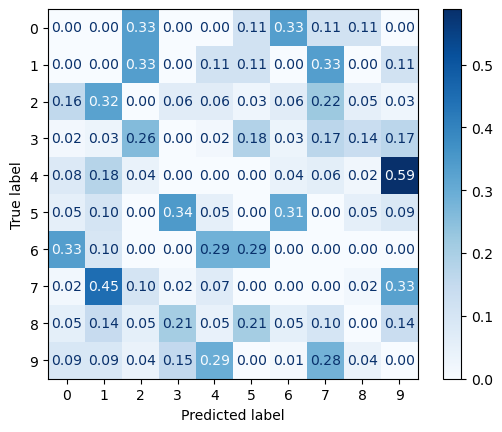

In [12]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_two_cmds(cmd1, cmd2, title1="Model 1 Confusion Matrix", title2="Model 2 Confusion Matrix"):


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first confusion matrix on the left
    cmd1.plot(ax=ax1, cmap='Blues', values_format='.2f')
    ax1.set_title(title1)

    # Plot the second confusion matrix on the right
    cmd2.plot(ax=ax2, cmap='Oranges', values_format='.2f')
    ax2.set_title(title2)

    plt.tight_layout()  # Ensure that the plots do not overlap
    plt.show()
    
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format='.2f')
sw = (y_test != y_pred)
cmd_error = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format='.2f', cmap='Blues', sample_weight=sw)


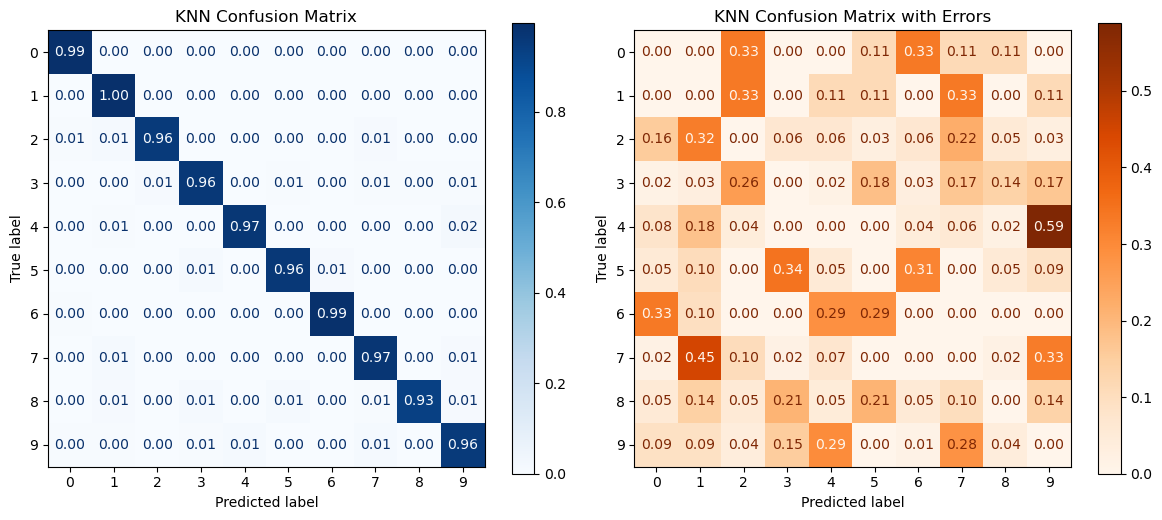

In [13]:
#plot confusion matrix
plot_two_cmds(cmd, cmd_error, title1="KNN Confusion Matrix", title2="KNN Confusion Matrix with Errors")

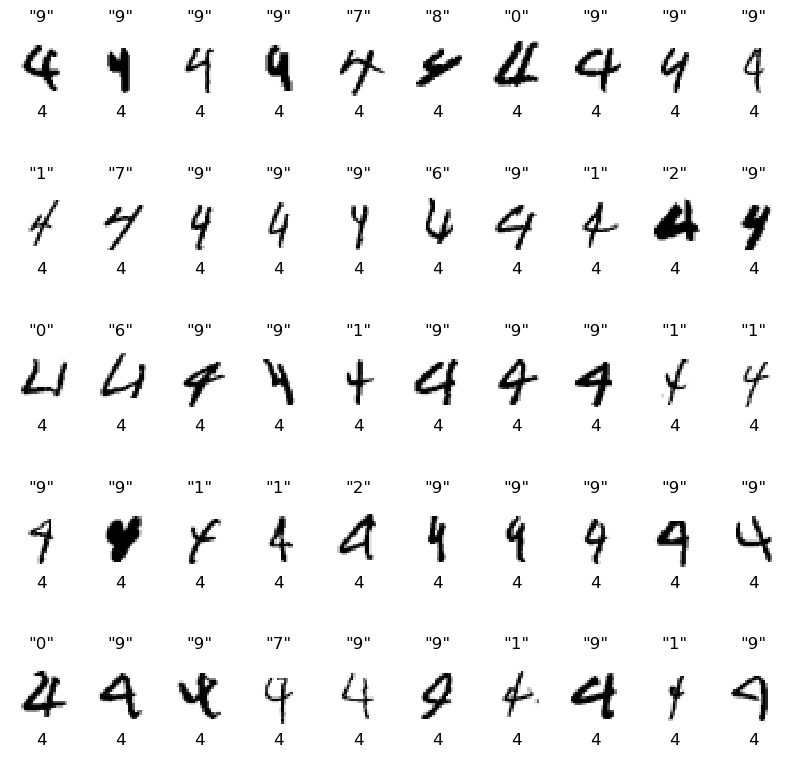

In [110]:
#print misclassified 
num = 4
X_num = X_test[y_test == str(num)]
y_num = y_test[y_test == str(num)]
y_pred_num = y_pred[y_test == str(num)]

misclassified = X_num[y_num != y_pred_num]
misclassified_labels = y_pred_num[y_num != y_pred_num]

#plot with actual labels and predicted labels
plot_digits(misclassified[0:50], y_num[0:50], misclassified_labels[0:50], images_per_row=10)


In [15]:
#optimize hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [10, 20, 30, 40, 50], 'p': [1, 2, 3]}
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# yGrid_pred = grid_search.predict(X_test)

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2, 3]
}

hgs = HalvingGridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
hgs.fit(X_train, y_train)

yGrid_pred = hgs.predict(X_test)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 216
max_resources_: 52500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 600
n_resources: 216
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
----------
iter: 1
n_candidates: 200
n_resources: 648
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
----------
iter: 2
n_candidates: 67
n_resources: 1944
Fitting 5 folds for each of 67 candidates, totalling 335 fits
----------
iter: 3
n_candidates: 23
n_resources: 5832
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 4
n_candidates: 8
n_resources: 17496
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [121]:
## Display the best parameters and scores
print("Best Parameters:", hgs.best_params_)
print("Best Score:", hgs.best_score_)
print("Best Estimator:", hgs.best_estimator_)
print("Best Index:", hgs.best_index_)

# #plot all results
# cvres = hgs.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)
    


Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
Best Score: 0.9615318662474992
Best Estimator: KNeighborsClassifier(algorithm='ball_tree', leaf_size=50, n_jobs=-1,
                     n_neighbors=3, p=3, weights='distance')
Best Index: 890


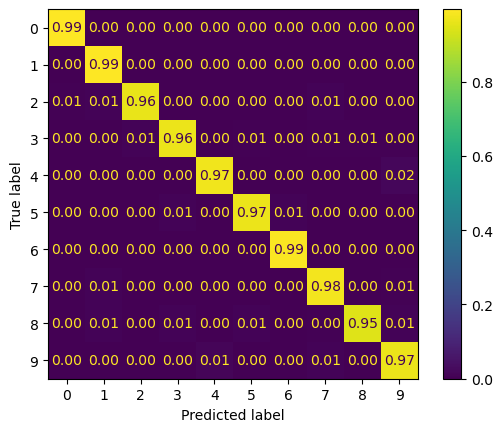

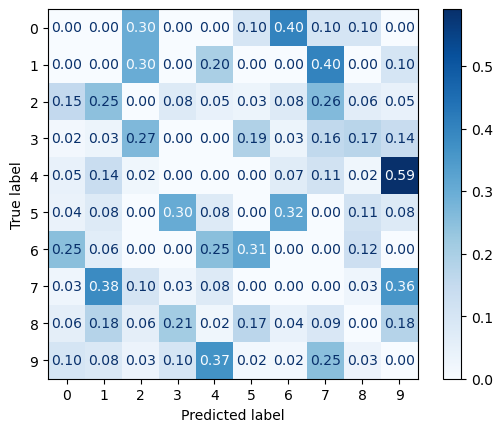

In [18]:
#plot confusion matrix
cmdGrid = ConfusionMatrixDisplay.from_predictions(y_test, yGrid_pred, normalize='true', values_format='.2f')
swGrid = (y_test != yGrid_pred)
cmdGrid_error = ConfusionMatrixDisplay.from_predictions(y_test, yGrid_pred, normalize='true', values_format='.2f', cmap='Blues', sample_weight=swGrid)


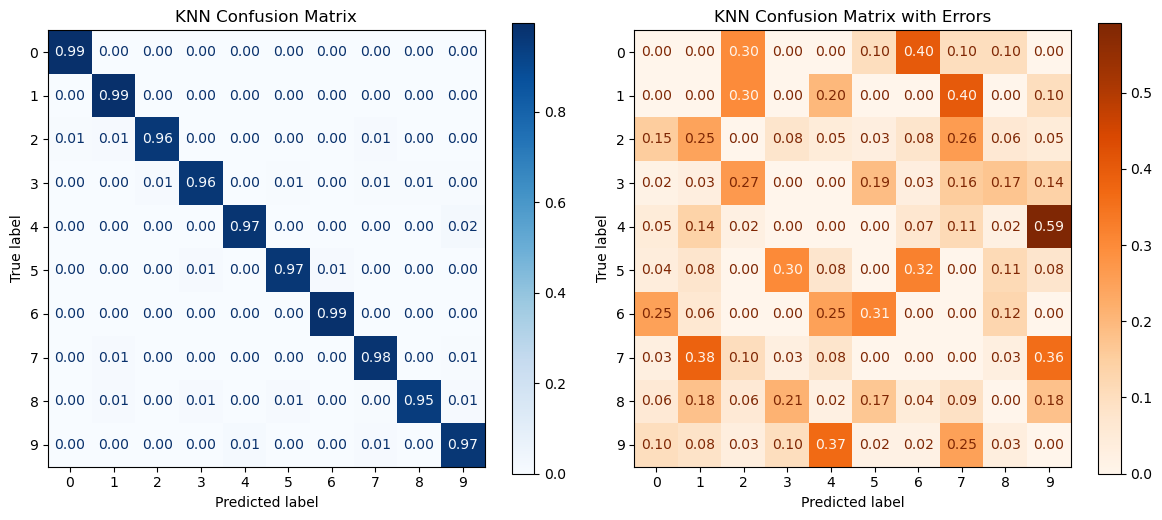

In [19]:
#plot confusion matrix
plot_two_cmds(cmdGrid, cmdGrid_error, title1="KNN Confusion Matrix", title2="KNN Confusion Matrix with Errors")

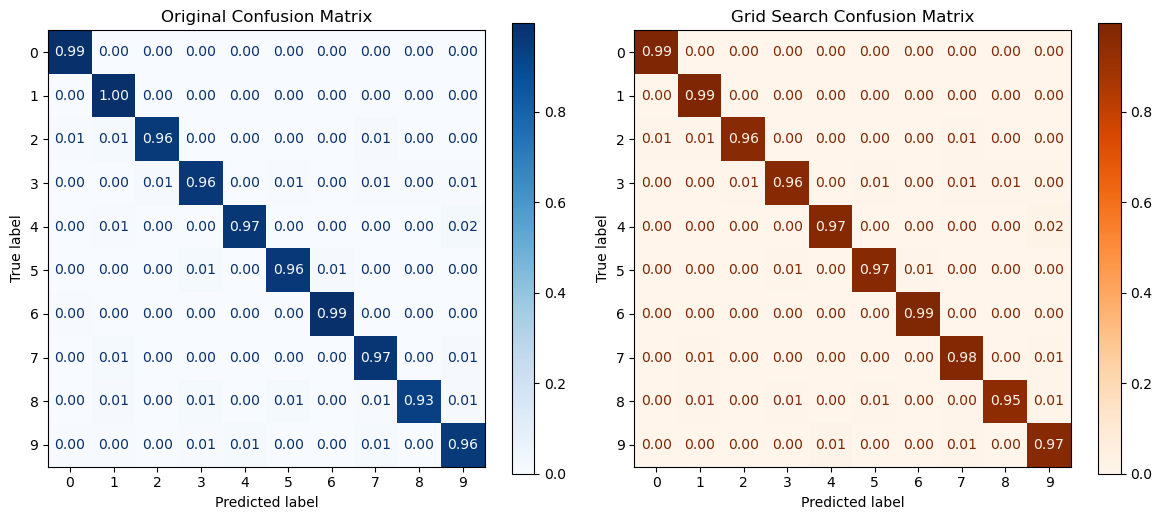

In [20]:
#plot two confusion matrix displays
plot_two_cmds(cmd, cmdGrid, title1="Original Confusion Matrix", title2="Grid Search Confusion Matrix")

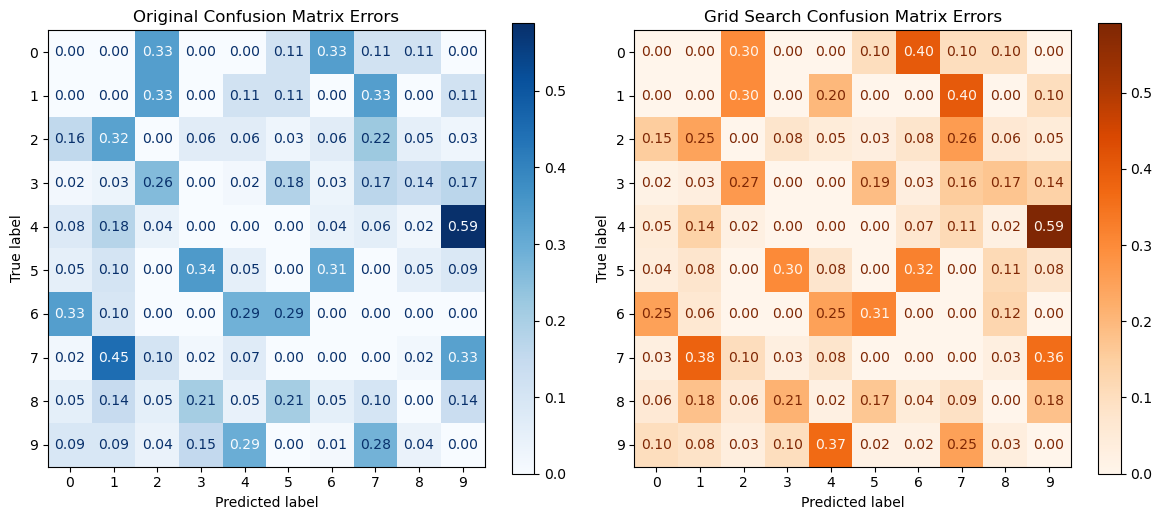

In [21]:
#plot their errors
plot_two_cmds(cmd_error, cmdGrid_error, title1="Original Confusion Matrix Errors", title2="Grid Search Confusion Matrix Errors")

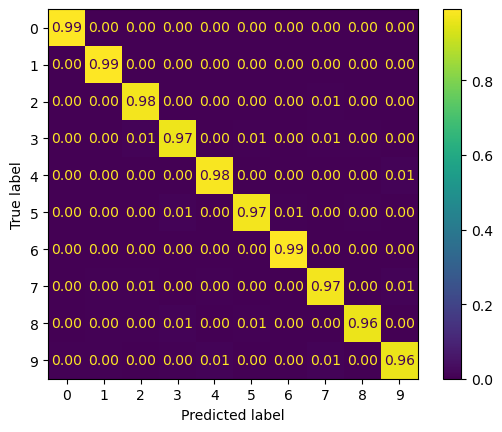

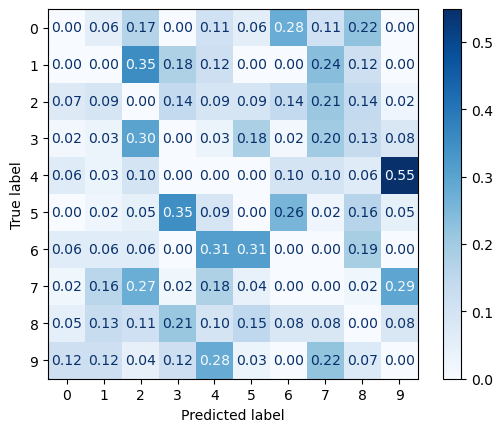

In [23]:
#SVC
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

ySVC_pred = svm_clf.predict(X_test)

cmdSVC = ConfusionMatrixDisplay.from_predictions(y_test, ySVC_pred, normalize='true', values_format='.2f')
swSVC = (y_test != ySVC_pred)
cmdSVC_error = ConfusionMatrixDisplay.from_predictions(y_test, ySVC_pred, normalize='true', values_format='.2f', cmap='Blues', sample_weight=swSVC)

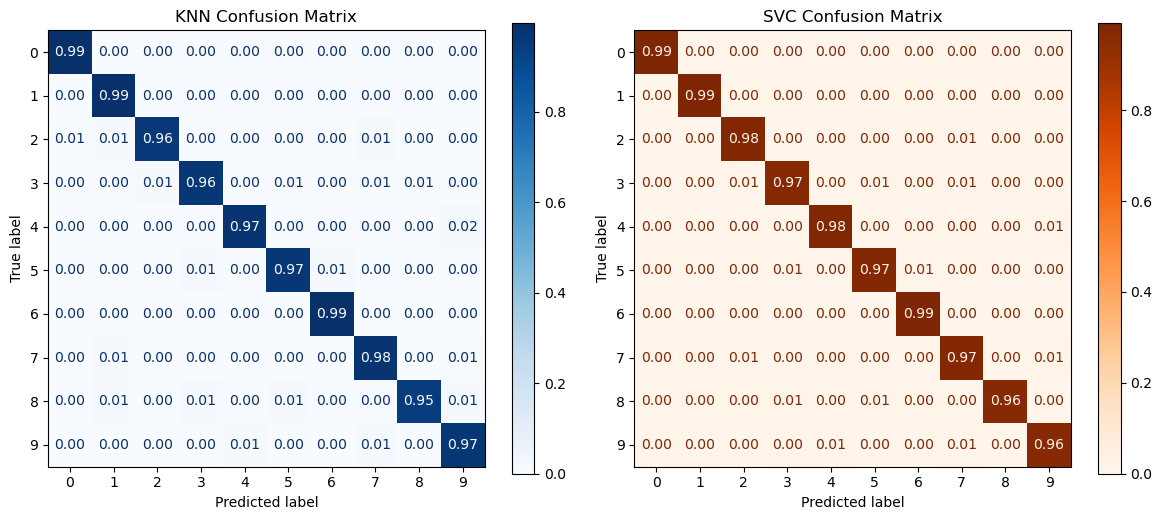

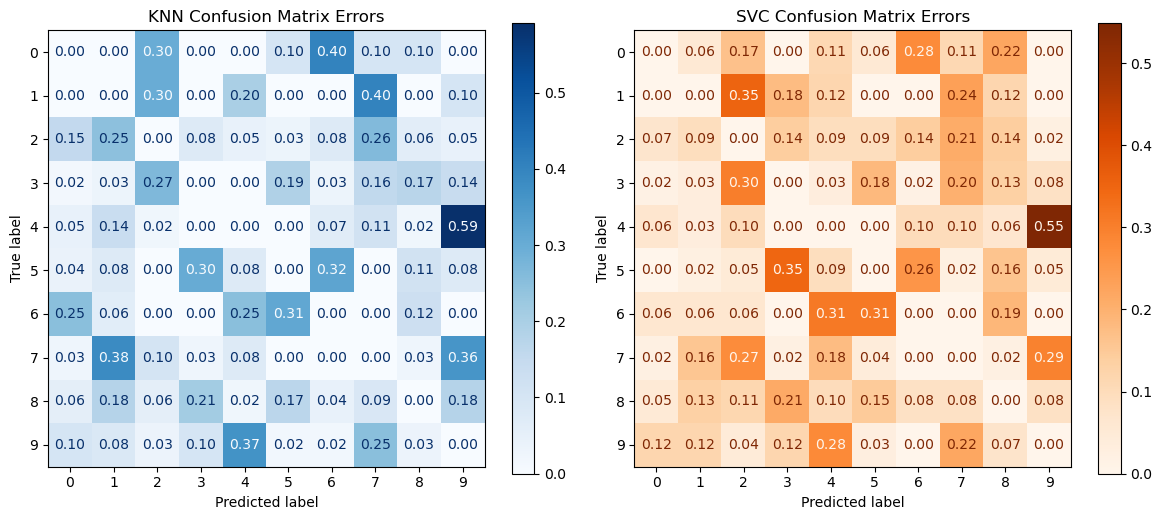

In [25]:
#plot two confusion matrix displays
plot_two_cmds(cmdGrid, cmdSVC, title1="KNN Confusion Matrix", title2="SVC Confusion Matrix")

#plot their errors
plot_two_cmds(cmdGrid_error, cmdSVC_error, title1="KNN Confusion Matrix Errors", title2="SVC Confusion Matrix Errors")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 648
max_resources_: 52500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 192
n_resources: 648
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 1
n_candidates: 64
n_resources: 1944
Fitting 3 folds for each of 64 candidates, totalling 192 fits
----------
iter: 2
n_candidates: 22
n_resources: 5832
Fitting 3 folds for each of 22 candidates, totalling 66 fits
----------
iter: 3
n_candidates: 8
n_resources: 17496
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 52488
Fitting 3 folds for each of 3 candidates, totalling 9 fits


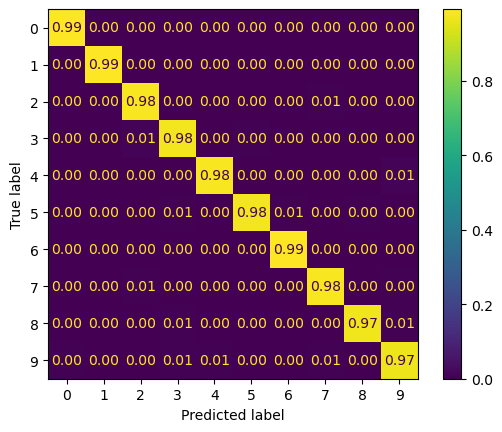

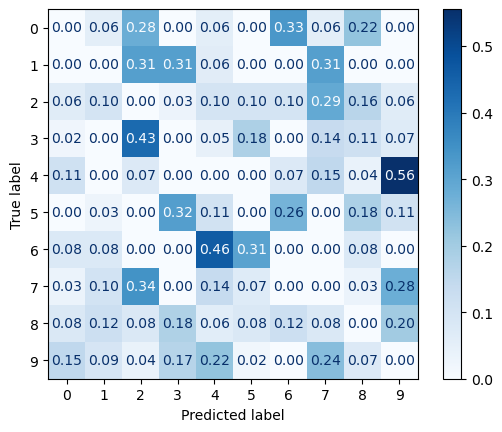

In [26]:
#halving grid search SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [1, 2, 3, 4, 5, 6]
}

hgsSVC = HalvingGridSearchCV(svm_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
hgsSVC.fit(X_train, y_train)


yGridSVC_pred = hgsSVC.predict(X_test)


cmdGridSVC = ConfusionMatrixDisplay.from_predictions(y_test, yGridSVC_pred, normalize='true', values_format='.2f')
swGridSVC = (y_test != yGridSVC_pred)
cmdGridSVC_error = ConfusionMatrixDisplay.from_predictions(y_test, yGridSVC_pred, normalize='true', values_format='.2f', cmap='Blues', sample_weight=swGridSVC)



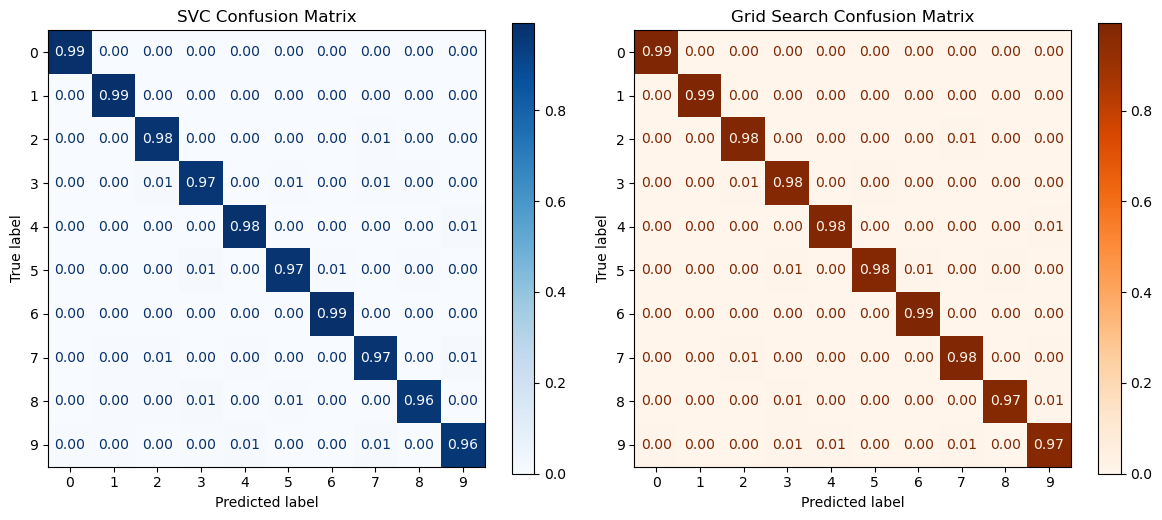

In [29]:
#plot two confusion matrix displays
plot_two_cmds(cmdSVC, cmdGridSVC, title1="SVC Confusion Matrix", title2="Grid Search Confusion Matrix")

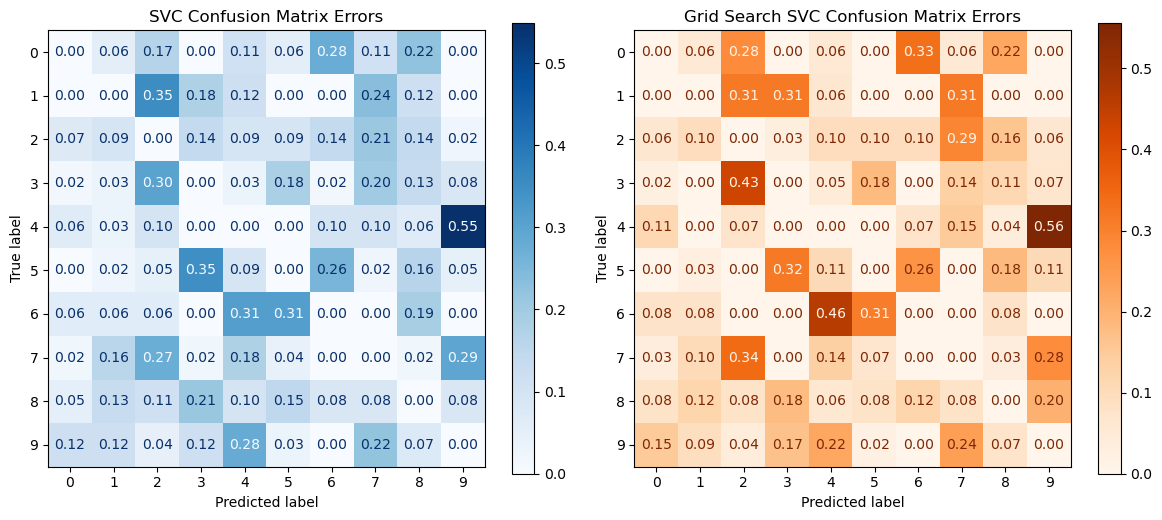

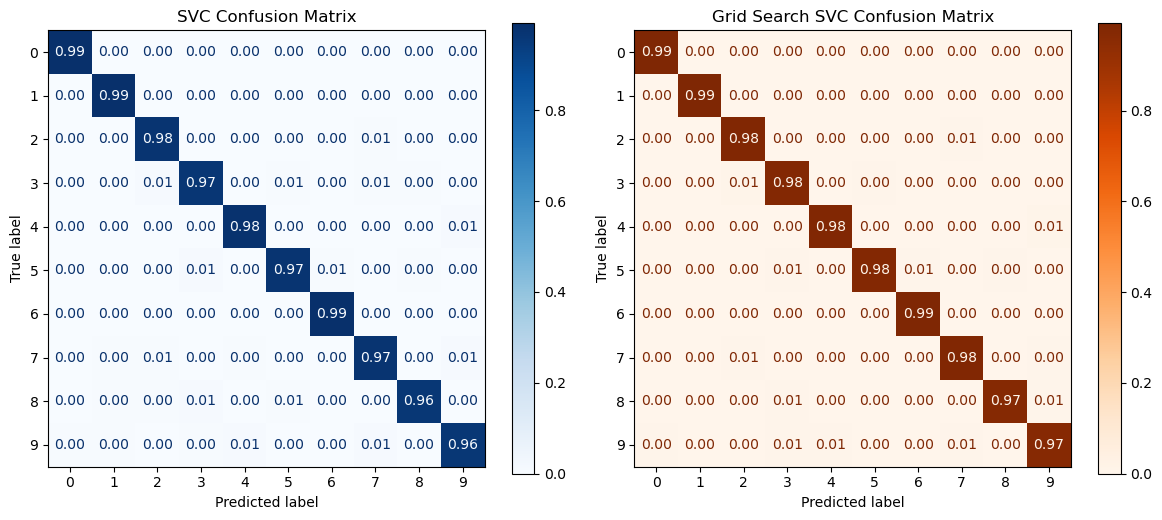

In [30]:
#compare
plot_two_cmds(cmdSVC_error, cmdGridSVC_error, title1="SVC Confusion Matrix Errors", title2="Grid Search SVC Confusion Matrix Errors")
plot_two_cmds(cmdSVC, cmdGridSVC, title1="SVC Confusion Matrix", title2="Grid Search SVC Confusion Matrix")

In [31]:
#Calssification Reports
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
print(classification_report(y_test, yGrid_pred))
print(classification_report(y_test, yGridSVC_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1714
           1       0.95      1.00      0.97      1977
           2       0.98      0.96      0.97      1761
           3       0.97      0.96      0.96      1806
           4       0.97      0.97      0.97      1587
           5       0.97      0.96      0.97      1607
           6       0.98      0.99      0.98      1761
           7       0.96      0.97      0.97      1878
           8       0.99      0.93      0.96      1657
           9       0.95      0.96      0.95      1752

    accuracy                           0.97     17500
   macro avg       0.97      0.97      0.97     17500
weighted avg       0.97      0.97      0.97     17500

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1714
           1       0.97      0.99      0.98      1977
           2       0.98      0.96      0.97      1761
           3       0.97 

In [122]:
#function to printout a number from both grid predictions and the original given an index
def print_num(index):
    print("KNN:", yGrid_pred[index])
    print("SVC:", yGridSVC_pred[index])
    print("Original:", y_test[index])
    plot_digit(X_test[index])

#index of misclassified number
indexOG = y_test != y_pred
indexGrid = y_test != yGrid_pred
indexGridSVC = y_test != yGridSVC_pred

In [127]:
#function to plot OG misclassified
def plot_compare_misclassified(index, ranges, page):
    print("-----------------------------------------------------------------------------------------------------------------------")
    print("KNN Default:")
    plot_digits(X_test[index][(ranges*(page-1)):(ranges*page)], y_test[index][(ranges*(page-1)):(ranges*page)], y_pred[index][(ranges*(page-1)):(ranges*page)], images_per_row=10)
    print("KNN Grid")
    plot_digits(X_test[index][(ranges*(page-1)):(ranges*page)], y_test[index][(ranges*(page-1)):(ranges*page)], yGrid_pred[index][(ranges*(page-1)):(ranges*page)], images_per_row=10)
    print("SVC Grid")
    plot_digits(X_test[index][(ranges*(page-1)):(ranges*page)], y_test[index][(ranges*(page-1)):(ranges*page)], yGridSVC_pred[index][(ranges*(page-1)):(ranges*page)], images_per_row=10)
    print("-----------------------------------------------------------------------------------------------------------------------")    


In [119]:
# plot_compare_misclassified(indexOG, 10, 1)
# plot_compare_misclassified(indexGrid, 10, 1)
# plot_compare_misclassified(indexGridSVC, 10, 1)

-----------------------------------------------------------------------------------------------------------------------
KNN Default:


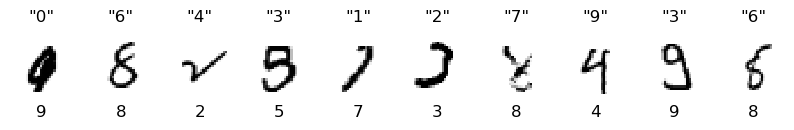

KNN Grid


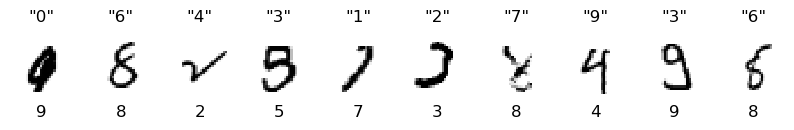

SVC Grid


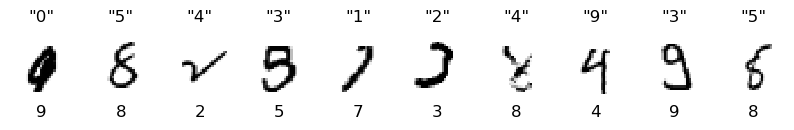

-----------------------------------------------------------------------------------------------------------------------


In [128]:
#get the index of the misclassified numbers that all three models got wrong
indexAll = np.logical_and(indexOG, indexGrid)
indexAll = np.logical_and(indexAll, indexGridSVC)

plot_compare_misclassified(indexAll, 10, 1)